In [ ]:
import torch
torch.cuda.empty_cache()

# BASED ON RANDOM SAMPLINGS

Faster R-CNN with MobileNetV3 because training and inference (even on CPU) are reasonably fast. I tried other models but they were taking too much time and resources, I felt it was more ideal for me to use a very light model just making a basic loop.

Once my loop feels decent, I would change to a heavier and more accurate model


What is mAP@0.5?

- mAP = mean Average Precision, a standard detection metric

- AP at a single IoU threshold (0.5) = area under the precision–recall curve when a predicted box is “correct” if IoU ≥ 0.5

- mean over classes (here only one “daisy” class) and averaged across images

In [46]:
import os
import random
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.transforms import functional as F, Resize
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Label map: {0: 1}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other th

Round 1/5, train=3
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

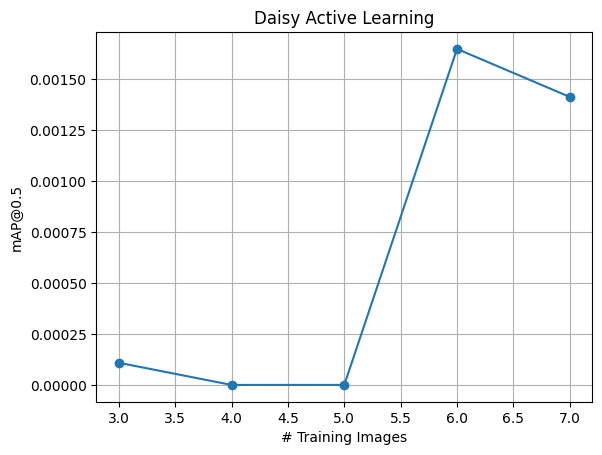

Inference done → test_results/


In [ ]:


# ---- Settings ----
TRAIN_JSON = "result.json"   
TRAIN_DIR  = "images"        
TEST_DIR   = "Test"          
CSV_FILE   = "labels.csv"
GT_JSON    = "ground_truth.json"
DEVICE     = torch.device("cpu")  

RESIZE = Resize((320, 320))
BATCH_SIZE = 1
INITIAL    = 3
VAL_SIZE   = 2
POOL_BATCH = 1
ROUNDS     = 5

# ---- Dataset ----
class DaisyDataset(Dataset):
    def __init__(self, csv, img_dir):
        self.df = pd.read_csv(csv)
        self.img_dir = img_dir
        self.imgs = self.df['image_path'].unique().tolist()
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        fn = self.imgs[idx]
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        img = RESIZE(img)
        recs = self.df[self.df['image_path'] == fn]
        boxes = recs[['xmin','ymin','xmax','ymax']].values.astype(np.float32)
        labels = recs['label'].values.astype(np.int64)
        target = {
            'boxes': torch.from_numpy(boxes),
            'labels': torch.from_numpy(labels),
            'image_id': torch.tensor([idx])
        }
        return F.to_tensor(img), target

def collate_fn(batch):
    return tuple(zip(*batch))

# ---- Parse COCO → CSV ----
def parse_coco(json_file, img_dir):
    coco = COCO(json_file)
    records = []
    for ann in coco.loadAnns(coco.getAnnIds()):
        img = coco.loadImgs(ann['image_id'])[0]
        fn = os.path.basename(img['file_name'])
        x,y,w,h = ann['bbox']
        records.append({
            'image_path': fn,
            'xmin': x, 'ymin': y,
            'xmax': x+w, 'ymax': y+h,
            'label_orig': ann['category_id']
        })
    df = pd.DataFrame(records)
    df.to_csv("labels_raw.csv", index=False)
    return df

# ---- Build COCO GT JSON ----
def build_coco_gt(df, out_json):
    images, anns, cats = [], [], []
    uniq = df['image_path'].unique().tolist()
    # images
    for i, fn in enumerate(uniq):
        images.append({
            'id': int(i),
            'file_name': fn
        })
    # annotations
    aid = 1
    for _, r in df.iterrows():
        x1 = int(r['xmin'])
        y1 = int(r['ymin'])
        x2 = int(r['xmax'])
        y2 = int(r['ymax'])
        w = x2 - x1
        h = y2 - y1
        anns.append({
            'id': int(aid),
            'image_id': int(uniq.index(r['image_path'])),
            'category_id': int(r['label']),
            'bbox': [x1, y1, w, h],
            'area': float(w * h),
            'iscrowd': 0
        })
        aid += 1
    # categories
    for cid in sorted(df['label'].unique()):
        cats.append({
            'id': int(cid),
            'name': str(cid)
        })
    coco_dict = {
        'info': {},
        'licenses': [],
        'images': images,
        'annotations': anns,
        'categories': cats
    }
    # write out
    with open(out_json, 'w') as f:
        json.dump(coco_dict, f)
    return COCO(out_json)


# ---- Training & Eval ----
def train_epoch(model, opt, loader, device):
    model.train()
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]
        losses = model(imgs, tgts)
        loss = sum(losses.values())
        opt.zero_grad()
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_map(model, loader, device, coco_gt):
    model.eval()
    preds = []
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        outs = model(imgs)
        for tgt, out in zip(tgts, outs):
            img_id = int(tgt['image_id'].item())
            for box, score, label in zip(out['boxes'].cpu(), out['scores'].cpu(), out['labels'].cpu()):
                x1,y1,x2,y2 = box.tolist()
                preds.append({
                    'image_id': img_id,
                    'category_id': int(label),
                    'bbox': [x1,y1,x2-x1,y2-y1],
                    'score': float(score)
                })
    if not preds:
        print("→ No detections, mAP@0.5=0.0")
        return 0.0
    with open("preds.json","w") as f:
        json.dump(preds, f)
    coco_dt = coco_gt.loadRes("preds.json")
    ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
    ev.params.imgIds = sorted(coco_gt.getImgIds())
    ev.evaluate(); ev.accumulate(); ev.summarize()
    return ev.stats[1]

# ---- Main ----
def main():
    # 1) parse COCO → raw labels
    df = parse_coco(TRAIN_JSON, TRAIN_DIR)
    # 2) remap labels → "Daisy" -> 1 
    mapping = {orig: i+1 for i,orig in enumerate(df['label_orig'].unique())}
    print("Label map:", mapping)
    df['label'] = df['label_orig'].map(mapping)
    df[['image_path','xmin','ymin','xmax','ymax','label']].to_csv(CSV_FILE, index=False)
    # 3) build COCO GT
    coco_gt = build_coco_gt(df, GT_JSON)

    # 4) prepare splits
    dataset = DaisyDataset(CSV_FILE, TRAIN_DIR)
    n_classes = df['label'].nunique() + 1
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    train_idx = idxs[:INITIAL]
    val_idx   = idxs[INITIAL:INITIAL+VAL_SIZE]
    pool_idx  = idxs[INITIAL+INITIAL+VAL_SIZE:]

    # 5) model & optimizer
    model = fasterrcnn_mobilenet_v3_large_320_fpn(
        pretrained=False,
        pretrained_backbone=True,
        num_classes=n_classes
    ).to(DEVICE)
    opt = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

    # 6) active learning loop
    perf, sizes = [], []
    for r in range(ROUNDS):
        print(f"Round {r+1}/{ROUNDS}, train={len(train_idx)}")
        tr_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader= DataLoader(Subset(dataset, val_idx),   batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_fn)

        train_epoch(model, opt, tr_loader, DEVICE)
        mAP50 = evaluate_map(model, val_loader, DEVICE, coco_gt)
        perf.append(mAP50); sizes.append(len(train_idx))

        if pool_idx:
            add = random.sample(pool_idx, min(POOL_BATCH, len(pool_idx)))
            train_idx += add
            pool_idx = [i for i in pool_idx if i not in add]
        else:
            break

    # 7) plot
    plt.plot(sizes, perf, marker='o')
    plt.xlabel("# Training Images"); plt.ylabel("mAP@0.5")
    plt.title("Daisy Active Learning"); plt.grid(True)
    plt.show()

    # 8) inference on TEST_DIR
    os.makedirs("test_results", exist_ok=True)
    model.eval()
    for fn in sorted(os.listdir(TEST_DIR)):
        if not fn.lower().endswith((".jpg",".png")): continue
        img = Image.open(os.path.join(TEST_DIR,fn)).convert("RGB")
        img = RESIZE(img)
        t = F.to_tensor(img).to(DEVICE)
        out = model([t])[0]
        draw = ImageDraw.Draw(img)
        for box, score in zip(out['boxes'].cpu(), out['scores'].cpu()):
            if score < 0.5: continue
            x1,y1,x2,y2 = box.tolist()
            draw.rectangle([x1,y1,x2,y2], outline="red", width=2)
            draw.text((x1,y1-10), f"{score:.2f}", fill="red")
        img.save(os.path.join("test_results", fn))
    print("Inference done → test_results/")

if __name__ == "__main__":
    main()

# Next Steps




- Plot a longer active learning curve
    - Run more rounds (e.g., up to 20–30 samples used), andplot mAP vs training size. That’s when performance shouldstart climbing meaningfully.
- Try a baseline using all 131 images
    - Train the model using more data and evaluate — this givesyou an upper bound on achievable mAP@0.5.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Label map: {0: 1}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other th

Round 1/28, train=3
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

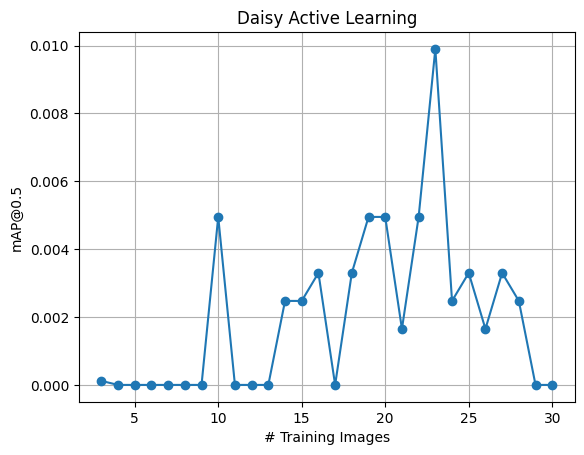

Baseline training on full dataset...


/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other th

 Baseline epoch 1/5
 Baseline epoch 2/5
 Baseline epoch 3/5
 Baseline epoch 4/5
 Baseline epoch 5/5
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [ ]:
# ---- Settings ----
TRAIN_JSON = "result.json"   
TRAIN_DIR  = "images"        
TEST_DIR   = "Test"          
CSV_FILE   = "labels.csv"
GT_JSON    = "ground_truth.json"
DEVICE     = torch.device("cpu")  

RESIZE     = Resize((320, 320))
BATCH_SIZE = 1
INITIAL    = 3
VAL_SIZE   = 2
POOL_BATCH = 1
ROUNDS     = 28  # run up to ~30 training samples


# ---- Main ----
def main():
    # 1) parse COCO → raw labels
    df = parse_coco(TRAIN_JSON, TRAIN_DIR)
    # 2) remap labels → 1…N
    mapping = {orig: i+1 for i,orig in enumerate(df['label_orig'].unique())}
    print("Label map:", mapping)
    df['label'] = df['label_orig'].map(mapping)
    df[['image_path','xmin','ymin','xmax','ymax','label']].to_csv(CSV_FILE, index=False)
    # 3) build COCO GT
    coco_gt = build_coco_gt(df, GT_JSON)

    # 4) prepare splits
    dataset = DaisyDataset(CSV_FILE, TRAIN_DIR)
    n_classes = df['label'].nunique() + 1
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    train_idx = idxs[:INITIAL]
    val_idx   = idxs[INITIAL:INITIAL+VAL_SIZE]
    pool_idx  = idxs[INITIAL+INITIAL+VAL_SIZE:]

    # 5) model & optimizer
    model = fasterrcnn_mobilenet_v3_large_320_fpn(
        pretrained=False,
        pretrained_backbone=True,
        num_classes=n_classes
    ).to(DEVICE)
    opt = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

    # 6) active learning loop
    perf, sizes = [], []
    for r in range(ROUNDS):
        print(f"Round {r+1}/{ROUNDS}, train={len(train_idx)}")
        tr_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader= DataLoader(Subset(dataset, val_idx),   batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_fn)

        train_epoch(model, opt, tr_loader, DEVICE)
        mAP50 = evaluate_map(model, val_loader, DEVICE, coco_gt)
        print(f"  mAP@0.5 = {mAP50:.4f}")
        perf.append(mAP50); sizes.append(len(train_idx))

        if pool_idx:
            add = random.sample(pool_idx, min(POOL_BATCH, len(pool_idx)))
            train_idx += add
            pool_idx = [i for i in pool_idx if i not in add]
        else:
            break

    # 7) plot
    plt.plot(sizes, perf, marker='o')
    plt.xlabel("# Training Images"); plt.ylabel("mAP@0.5")
    plt.title("Daisy Active Learning"); plt.grid(True); plt.show()

    # 8) baseline on full dataset
    print("Baseline training on full dataset...")
    base_model = fasterrcnn_mobilenet_v3_large_320_fpn(
        pretrained=False,
        pretrained_backbone=True,
        num_classes=n_classes
    ).to(DEVICE)
    base_opt = torch.optim.SGD(base_model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    for ep in range(5):
        print(f" Baseline epoch {ep+1}/5")
        train_epoch(base_model, base_opt, full_loader, DEVICE)
    base_mAP = evaluate_map(
        base_model,
        DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn),
        DEVICE, coco_gt
    )
    print(f"Baseline mAP@0.5 on validation set: {base_mAP:.4f}")

    # 9) inference on TEST_DIR
    os.makedirs("test_results", exist_ok=True)
    model.eval()
    for fn in sorted(os.listdir(TEST_DIR)):
        if not fn.lower().endswith((".jpg",".png")): continue
        img = Image.open(os.path.join(TEST_DIR,fn)).convert("RGB")
        img = RESIZE(img)
        t = F.to_tensor(img).to(DEVICE)
        out = model([t])[0]
        draw = ImageDraw.Draw(img)
        for box, score in zip(out['boxes'].cpu(), out['scores'].cpu()):
            if score < 0.5: continue
            x1,y1,x2,y2 = box.tolist()
            draw.rectangle([x1,y1,x2,y2], outline="red", width=2)
            draw.text((x1,y1-10), f"{score:.2f}", fill="red")
        img.save(os.path.join("test_results", fn))
    print("Inference done → test_results/")

if __name__ == "__main__":
    main()


# INTRODUCED UNCERTAINTY SAMPLINGS

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Label map: {0: 1}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other th

Round 1/14, train=3
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

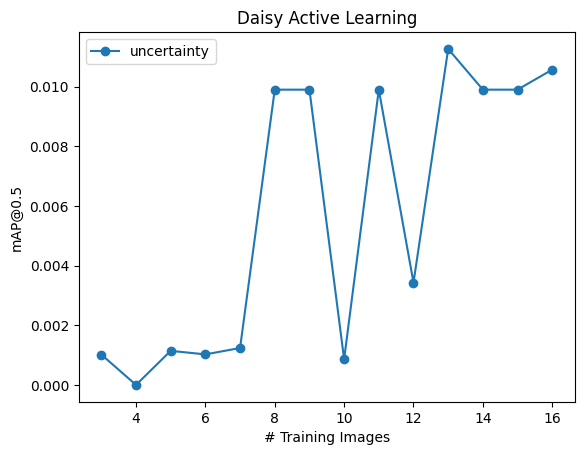

In [ ]:
# ---- Settings ----
TRAIN_JSON = "result.json"
TRAIN_DIR  = "images"
TEST_DIR   = "Test"
CSV_FILE   = "labels.csv"
GT_JSON    = "ground_truth.json"
DEVICE     = torch.device("cpu")
RESIZE     = Resize((320, 320))
BATCH_SIZE = 1
INITIAL    = 3
VAL_SIZE   = 2
POOL_BATCH = 1
ROUNDS     = 14

# sampling strategy: 'random' or 'uncertainty'
SAMPLING   = 'uncertainty'

class DaisyDataset(Dataset):
    def __init__(self, csv, img_dir):
        self.df = pd.read_csv(csv)
        self.img_dir = img_dir
        self.imgs = self.df['image_path'].unique().tolist()
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        fn = self.imgs[idx]
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        img = RESIZE(img)
        recs = self.df[self.df['image_path'] == fn]
        boxes = recs[['xmin','ymin','xmax','ymax']].values.astype(np.float32)
        labels = recs['label'].values.astype(np.int64)
        target = {'boxes': torch.from_numpy(boxes), 'labels': torch.from_numpy(labels), 'image_id': torch.tensor([idx])}
        return F.to_tensor(img), target

def collate_fn(batch):
    return tuple(zip(*batch))

def parse_coco(json_file, img_dir):
    coco = COCO(json_file)
    records = []
    for ann in coco.loadAnns(coco.getAnnIds()):
        img = coco.loadImgs(ann['image_id'])[0]
        fn = os.path.basename(img['file_name'])
        x,y,w,h = ann['bbox']
        records.append({'image_path': fn, 'xmin': x, 'ymin': y, 'xmax': x+w, 'ymax': y+h, 'label_orig': ann['category_id']})
    df = pd.DataFrame(records)
    df.to_csv("labels_raw.csv", index=False)
    return df

def build_coco_gt(df, out_json):
    images, anns, cats = [], [], []
    uniq = df['image_path'].unique().tolist()
    for i, fn in enumerate(uniq): images.append({'id': i, 'file_name': fn})
    aid = 1
    for _, r in df.iterrows():
        x1,y1,x2,y2 = map(int, [r['xmin'], r['ymin'], r['xmax'], r['ymax']])
        w, h = x2-x1, y2-y1
        anns.append({'id': aid, 'image_id': uniq.index(r['image_path']), 'category_id': int(r['label']), 'bbox': [x1,y1,w,h], 'area': float(w*h), 'iscrowd': 0})
        aid += 1
    for cid in sorted(df['label'].unique()): cats.append({'id': int(cid), 'name': str(cid)})
    coco_dict = {'info':{}, 'licenses':[], 'images':images, 'annotations':anns, 'categories':cats}
    with open(out_json, 'w') as f: json.dump(coco_dict, f)
    return COCO(out_json)

def train_epoch(model, opt, loader, device):
    model.train()
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]
        losses = model(imgs, tgts)
        loss = sum(losses.values())
        opt.zero_grad()
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_map(model, loader, device, coco_gt):
    model.eval()
    preds = []
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        outs = model(imgs)
        for tgt, out in zip(tgts, outs):
            img_id = int(tgt['image_id'].item())
            for box, score, label in zip(out['boxes'].cpu(), out['scores'].cpu(), out['labels'].cpu()):
                x1,y1,x2,y2 = box.tolist()
                preds.append({'image_id': img_id, 'category_id': int(label), 'bbox': [x1,y1,x2-x1,y2-y1], 'score': float(score)})
    if not preds:
        print("→ No detections, mAP@0.5=0.0")
        return 0.0
    with open("preds.json","w") as f: json.dump(preds, f)
    coco_dt = coco_gt.loadRes("preds.json")
    ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
    ev.params.imgIds = sorted(coco_gt.getImgIds())
    ev.evaluate(); ev.accumulate(); ev.summarize()
    return ev.stats[1]

@torch.no_grad()
def select_uncertain(pool_idx, dataset, model, device, k):
    uncertainties = []
    for idx in pool_idx:
        img, _ = dataset[idx]
        out = model([img.to(device)])[0]
        max_score = out['scores'].max().item() if len(out['scores'])>0 else 0.0
        uncertainties.append((1 - max_score, idx))
    uncertainties.sort(reverse=True, key=lambda x: x[0])
    return [idx for _, idx in uncertainties[:k]]

def main():
    df = parse_coco(TRAIN_JSON, TRAIN_DIR)
    mapping = {orig: i+1 for i, orig in enumerate(df['label_orig'].unique())}
    print("Label map:", mapping)
    df['label'] = df['label_orig'].map(mapping)
    df[['image_path','xmin','ymin','xmax','ymax','label']].to_csv(CSV_FILE, index=False)
    coco_gt = build_coco_gt(df, GT_JSON)

    dataset = DaisyDataset(CSV_FILE, TRAIN_DIR)
    n_classes = df['label'].nunique() + 1
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    train_idx = idxs[:INITIAL]
    val_idx   = idxs[INITIAL:INITIAL+VAL_SIZE]
    pool_idx  = idxs[INITIAL+INITIAL+VAL_SIZE:]

    model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False, pretrained_backbone=True, num_classes=n_classes).to(DEVICE)
    opt   = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

    perf, sizes = [], []
    for r in range(ROUNDS):
        print(f"Round {r+1}/{ROUNDS}, train={len(train_idx)}")
        tr_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader= DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        train_epoch(model, opt, tr_loader, DEVICE)
        mAP50 = evaluate_map(model, val_loader, DEVICE, coco_gt)
        print(f"  mAP@0.5 = {mAP50:.4f}")
        perf.append(mAP50); sizes.append(len(train_idx))

        if not pool_idx:
            break

        if SAMPLING == 'random':
            add = random.sample(pool_idx, min(POOL_BATCH, len(pool_idx)))
        else:
            add = select_uncertain(pool_idx, dataset, model, DEVICE, min(POOL_BATCH, len(pool_idx)))
        train_idx += add
        pool_idx  = [i for i in pool_idx if i not in add]

    plt.plot(sizes, perf, marker='o', label=SAMPLING)
    plt.xlabel("# Training Images"); plt.ylabel("mAP@0.5")
    plt.title("Daisy Active Learning"); plt.legend(); plt.show()

if __name__ == "__main__":
    main()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' in

Random     → Round 1/48, train=3
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.5

/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/nakshatra/Documents/gsoc/DeepForest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' in

Uncertainty → Round 1/48, train=3
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.

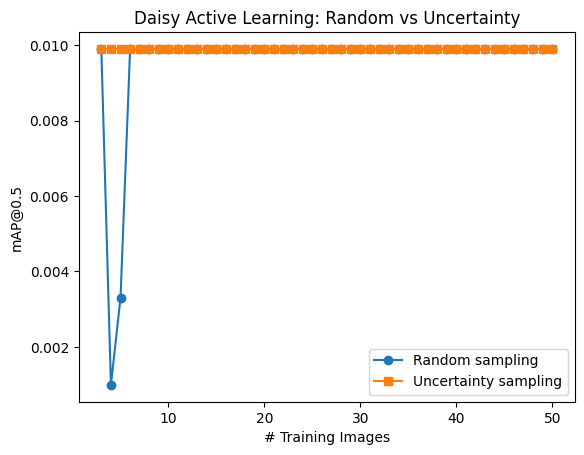

In [8]:
import os
import random
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F, Resize
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
import matplotlib.pyplot as plt

# ---- Settings ----
TRAIN_JSON        = "result.json"
TRAIN_DIR         = "images"
CSV_FILE          = "labels.csv"
GT_JSON           = "ground_truth.json"
DEVICE            = torch.device("cpu")
RESIZE            = Resize((320, 320))
BATCH_SIZE        = 1
INITIAL           = 3
VAL_SIZE          = 2
POOL_BATCH        = 1
ROUNDS            = 48
EPOCHS_PER_ROUND  = 5
SAMPLINGS         = ['random', 'uncertainty']

class DaisyDataset(Dataset):
    def __init__(self, csv, img_dir):
        self.df = pd.read_csv(csv)
        self.img_dir = img_dir
        self.imgs = self.df['image_path'].unique().tolist()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        fn = self.imgs[idx]
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        img = RESIZE(img)
        recs = self.df[self.df['image_path'] == fn]
        boxes = recs[['xmin','ymin','xmax','ymax']].values.astype(np.float32)
        labels = recs['label'].values.astype(np.int64)
        target = {
            'boxes': torch.from_numpy(boxes),
            'labels': torch.from_numpy(labels),
            'image_id': torch.tensor([idx])
        }
        return F.to_tensor(img), target

def collate_fn(batch):
    return tuple(zip(*batch))

def parse_coco(json_file, img_dir):
    coco = COCO(json_file)
    records = []
    for ann in coco.loadAnns(coco.getAnnIds()):
        img = coco.loadImgs(ann['image_id'])[0]
        fn = os.path.basename(img['file_name'])
        x,y,w,h = ann['bbox']
        records.append({
            'image_path': fn,
            'xmin': x,
            'ymin': y,
            'xmax': x+w,
            'ymax': y+h,
            'label_orig': ann['category_id']
        })
    df = pd.DataFrame(records)
    return df

def build_coco_gt(df, out_json):
    images, anns, cats = [], [], []
    uniq = df['image_path'].unique().tolist()
    for i, fn in enumerate(uniq):
        images.append({'id': i, 'file_name': fn})
    aid = 1
    for _, r in df.iterrows():
        x1,y1,x2,y2 = map(int, [r['xmin'], r['ymin'], r['xmax'], r['ymax']])
        w, h = x2-x1, y2-y1
        anns.append({
            'id': aid,
            'image_id': uniq.index(r['image_path']),
            'category_id': int(r['label']),
            'bbox': [x1, y1, w, h],
            'area': float(w*h),
            'iscrowd': 0
        })
        aid += 1
    for cid in sorted(df['label'].unique()):
        cats.append({'id': int(cid), 'name': str(cid)})
    coco_dict = {
        'info': {}, 'licenses': [], 
        'images': images, 
        'annotations': anns, 
        'categories': cats
    }
    with open(out_json, 'w') as f:
        json.dump(coco_dict, f)
    return COCO(out_json)

def train_epoch(model, opt, loader, device):
    model.train()
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k: v.to(device) for k, v in t.items()} for t in tgts]
        losses = model(imgs, tgts)
        loss = sum(losses.values())
        opt.zero_grad()
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_map(model, loader, device, coco_gt):
    model.eval()
    preds = []
    for imgs, tgts in loader:
        imgs = [i.to(device) for i in imgs]
        outs = model(imgs)
        for tgt, out in zip(tgts, outs):
            img_id = int(tgt['image_id'].item())
            for box, score, label in zip(
                out['boxes'].cpu(),
                out['scores'].cpu(),
                out['labels'].cpu()
            ):
                x1,y1,x2,y2 = box.tolist()
                preds.append({
                    'image_id': img_id,
                    'category_id': int(label),
                    'bbox': [x1, y1, x2-x1, y2-y1],
                    'score': float(score)
                })
    if not preds:
        print("→ No detections, mAP@0.5=0.0")
        return 0.0
    with open("preds.json","w") as f:
        json.dump(preds, f)
    coco_dt = coco_gt.loadRes("preds.json")
    ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
    ev.params.imgIds = sorted(coco_gt.getImgIds())
    ev.evaluate(); ev.accumulate(); ev.summarize()
    return ev.stats[1]

@torch.no_grad()
def select_uncertain(pool_idx, dataset, model, device, k):
    uncertainties = []
    for idx in pool_idx:
        img, _ = dataset[idx]
        out = model([img.to(device)])[0]
        max_score = out['scores'].max().item() if len(out['scores'])>0 else 0.0
        uncertainties.append((1 - max_score, idx))
    uncertainties.sort(reverse=True, key=lambda x: x[0])
    return [idx for _, idx in uncertainties[:k]]

def run_rounds(strategy, dataset, n_classes, coco_gt, device):
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    train_idx = idxs[:INITIAL]
    val_idx   = idxs[INITIAL:INITIAL+VAL_SIZE]
    pool_idx  = idxs[INITIAL+INITIAL+VAL_SIZE:]

    model = fasterrcnn_mobilenet_v3_large_320_fpn(
        pretrained=True,
        pretrained_backbone=True
    )
    # replace the head for our num classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
    model.to(device)

    opt = torch.optim.SGD(
        model.parameters(),
        lr=0.005,
        momentum=0.9,
        weight_decay=5e-4
    )

    sizes, perf = [], []
    for r in range(ROUNDS):
        print(f"{strategy.title():10s} → Round {r+1}/{ROUNDS}, train={len(train_idx)}")
        tr_loader = DataLoader(
            Subset(dataset, train_idx),
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn
        )
        for e in range(EPOCHS_PER_ROUND):
            train_epoch(model, opt, tr_loader, device)

        val_loader = DataLoader(
            Subset(dataset, val_idx),
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn
        )
        mAP50 = evaluate_map(model, val_loader, device, coco_gt)

        sizes.append(len(train_idx))
        perf.append(mAP50)

        if not pool_idx:
            break
        if strategy == 'random':
            add = random.sample(pool_idx, min(POOL_BATCH, len(pool_idx)))
        else:
            add = select_uncertain(pool_idx, dataset, model, device,
                                   min(POOL_BATCH, len(pool_idx)))
        train_idx += add
        pool_idx  = [i for i in pool_idx if i not in add]

    return sizes, perf

if __name__ == "__main__":
    df = parse_coco(TRAIN_JSON, TRAIN_DIR)
    mapping = {orig: i+1 for i, orig in enumerate(df['label_orig'].unique())}
    df['label'] = df['label_orig'].map(mapping)
    df[['image_path','xmin','ymin','xmax','ymax','label']].to_csv(CSV_FILE, index=False)
    coco_gt = build_coco_gt(df, GT_JSON)
    dataset = DaisyDataset(CSV_FILE, TRAIN_DIR)
    n_classes = df['label'].nunique() + 1  # + background

    results = {}
    for strat in SAMPLINGS:
        sizes, perf = run_rounds(strat, dataset, n_classes, coco_gt, DEVICE)
        results[strat] = (sizes, perf)

    # plot both curves
    plt.plot(*results['random'],      marker='o', label='Random sampling')
    plt.plot(*results['uncertainty'], marker='s', label='Uncertainty sampling')
    plt.xlabel("# Training Images")
    plt.ylabel("mAP@0.5")
    plt.title("Daisy Active Learning: Random vs Uncertainty")
    plt.legend()
    plt.show()
